In [1]:
import data_bert
import model_bert_evaluation_pipeline
import model_bert_tree_evaluation_pipeline
import model_bert_evaluation_helpers
import config
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tsum = 0

for topic_num_id in np.unique(data_bert.train_topics_num_id):
    left = np.searchsorted(data_bert.has_correlation_train_topics, topic_num_id, side="left")
    right = np.searchsorted(data_bert.has_correlation_train_topics, topic_num_id, side="right")
    
    real_contents = data_bert.has_correlation_train_contents[left:right]
    
    if len(real_contents) > 0:
        if os.path.isfile("D:/KaggleLearningEquality2023/data/model_eval_tree/topics_tree_overshoot_small_trained_on_test_eval_train/" + str(topic_num_id) + ".npy"):
            pred_contents = np.load("D:/KaggleLearningEquality2023/data/model_eval_tree/topics_tree_overshoot_small_trained_on_test_eval_train/" + str(topic_num_id) + ".npy")
        else:
            pred_contents = np.array([])

        intersect = pred_contents[data_bert.fast_contains_multi(real_contents, pred_contents)]
        tsum += len(intersect) / len(real_contents)
    else:
        tsum += 1
print(tsum, "   ", tsum / len(np.unique(data_bert.train_topics_num_id)))

41089.624855650756     0.8297079105799479


In [3]:
topics = data_bert.topics
topics_inv_map = pd.Series(data=np.arange(len(topics)), index=topics.index)
topic_trees = []
total_nodes = []
total_nodes_by_tid = np.empty(shape = len(topics), dtype="object")
for str_id in topics.loc[topics["level"] == 0].index:
    node = model_bert_tree_evaluation_pipeline.Node(level=0, topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
    topic_trees.append(node)
    total_nodes.append(node)
    total_nodes_by_tid[topics_inv_map[str_id]] = node

# generate tree structure
for level in range(np.max(topics["level"].unique())):
    for str_id in topics.loc[topics["level"] == (level + 1)].index:
        parent = model_bert_tree_evaluation_pipeline.find_node_by_str_id(total_nodes, topics.loc[str_id, "parent"])

        node = model_bert_tree_evaluation_pipeline.Node(level=(level+1), topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
        node.parent = parent
        parent.children.append(node)

        total_nodes.append(node)
        total_nodes_by_tid[node.topic_num_id] = node

topic_id_to_preorder_id = np.zeros(shape=len(total_nodes), dtype=np.int32)
topic_id_to_subtree_end = np.zeros(shape=len(total_nodes), dtype=np.int32)
preorder_id_to_topic_id = np.zeros(shape=len(total_nodes), dtype=np.int32)

cur_id = 0
for node in topic_trees:
    cur_id = model_bert_tree_evaluation_pipeline.compute_preorder_id(node, cur_id, topic_id_to_preorder_id, preorder_id_to_topic_id, topic_id_to_subtree_end) + 1

In [4]:
def compute_expanded_tree(node, min_subtree_size):
    for child in node.children:
        compute_expanded_tree(child, min_subtree_size)
    
    if node.subtree_end_id - node.preorder_id < min_subtree_size:
        cnode = node
        while cnode.parent is not None:
            cnode = cnode.parent
            if cnode.subtree_end_id - cnode.preorder_id >= min_subtree_size:
                break
        node.least_subtree = cnode
    else:
        node.least_subtree = node

In [14]:
mapping_dict = {}
for min_expand in range(1,30):
    for node in topic_trees:
        compute_expanded_tree(node, min_expand)
    mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
    for k in range(len(data_bert.topics)):
        topic_str_id = data_bert.topics.index[k]
        node = total_nodes_by_tid[k]
        mapping[k] = node.least_subtree.topic_num_id
    mapping_dict[min_expand] = mapping

Computed metrics of 0 out of 49523
0.0
Computed metrics of 200 out of 49523
2.707732677459717
Computed metrics of 400 out of 49523
2.7933902740478516
Computed metrics of 600 out of 49523
2.8525755405426025
Computed metrics of 800 out of 49523
2.598940849304199
Computed metrics of 1000 out of 49523
2.793306350708008
Computed metrics of 1200 out of 49523
2.8803234100341797
Computed metrics of 1400 out of 49523
2.897559881210327
Computed metrics of 1600 out of 49523
2.896054983139038
Computed metrics of 1800 out of 49523
2.924330949783325
Computed metrics of 2000 out of 49523
2.69863224029541
Computed metrics of 2200 out of 49523
2.887202024459839
Computed metrics of 2400 out of 49523
2.6527628898620605
Computed metrics of 2600 out of 49523
2.9235925674438477
Computed metrics of 2800 out of 49523
2.786487102508545
Computed metrics of 3000 out of 49523
2.812514543533325
Computed metrics of 3200 out of 49523
2.887143611907959
Computed metrics of 3400 out of 49523
2.8489763736724854
Computed

Computed metrics of 28800 out of 49523
2.6453347206115723
Computed metrics of 29000 out of 49523
2.5357141494750977
Computed metrics of 29200 out of 49523
2.517449378967285
Computed metrics of 29400 out of 49523
2.637103796005249
Computed metrics of 29600 out of 49523
2.544090986251831
Computed metrics of 29800 out of 49523
2.7302603721618652
Computed metrics of 30000 out of 49523
2.6674184799194336
Computed metrics of 30200 out of 49523
2.923647403717041
Computed metrics of 30400 out of 49523
2.5901458263397217
Computed metrics of 30600 out of 49523
2.6312551498413086
Computed metrics of 30800 out of 49523
2.6215598583221436
Computed metrics of 31000 out of 49523
2.6145448684692383
Computed metrics of 31200 out of 49523
2.6675937175750732
Computed metrics of 31400 out of 49523
2.4939217567443848
Computed metrics of 31600 out of 49523
2.651758909225464
Computed metrics of 31800 out of 49523
2.5999603271484375
Computed metrics of 32000 out of 49523
2.6743321418762207
Computed metrics of

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.996646,0.009044,0.984593,0.039117,0.998680,0.002512,0.012433,0.984593,0.015445
2,0.998661,0.002234,0.969634,0.010838,0.999489,0.001277,0.006352,0.969634,0.030405
3,0.998773,0.001992,0.965303,0.009704,0.999584,0.001118,0.005564,0.965303,0.034736
4,0.998833,0.001805,0.960570,0.008809,0.999613,0.000984,0.004900,0.960570,0.039469
5,0.998853,0.001613,0.955591,0.007885,0.999619,0.000874,0.004353,0.955591,0.044448
6,0.998954,0.001422,0.950435,0.006971,0.999649,0.000783,0.003902,0.950435,0.049603
7,0.998995,0.001293,0.946408,0.006344,0.999661,0.000724,0.003610,0.946408,0.053631
8,0.998999,0.001161,0.942564,0.005705,0.999667,0.000676,0.003369,0.942564,0.057475
9,0.999059,0.001061,0.939141,0.005221,0.999685,0.000638,0.003180,0.939141,0.060898
10,0.999059,0.000968,0.935583,0.004769,0.999685,0.000602,0.003005,0.935583,0.064456


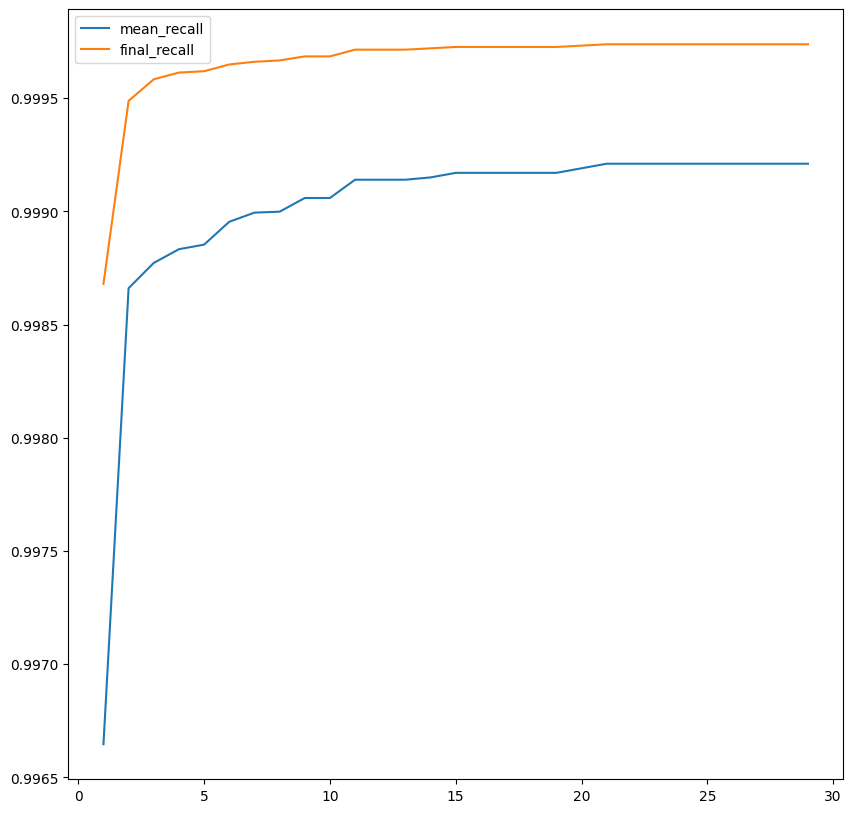

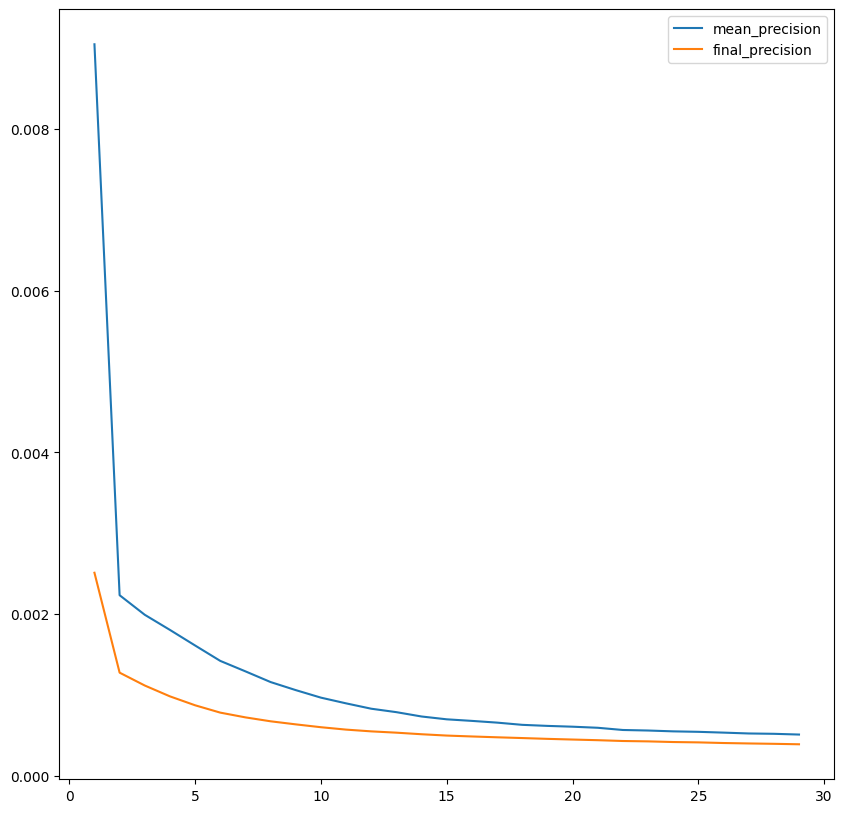

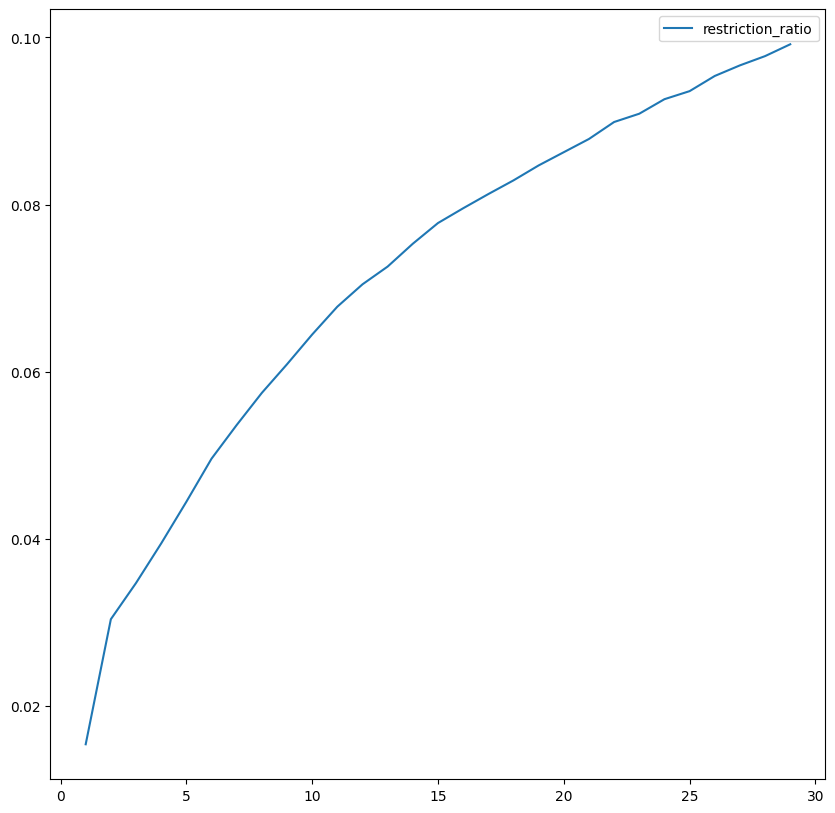

In [5]:
folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.train_topics_num_id,
                                                                   data_bert.train_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

Computed metrics of 0 out of 25338
0.03125190734863281
Computed metrics of 200 out of 25338
2.677992343902588
Computed metrics of 400 out of 25338
2.427773952484131
Computed metrics of 600 out of 25338
2.7228429317474365
Computed metrics of 800 out of 25338
2.629514217376709
Computed metrics of 1000 out of 25338
2.6616246700286865
Computed metrics of 1200 out of 25338
2.5671229362487793
Computed metrics of 1400 out of 25338
2.5466604232788086
Computed metrics of 1600 out of 25338
2.630650043487549
Computed metrics of 1800 out of 25338
2.5836005210876465
Computed metrics of 2000 out of 25338
2.4328064918518066
Computed metrics of 2200 out of 25338
2.732126474380493
Computed metrics of 2400 out of 25338
2.551959991455078
Computed metrics of 2600 out of 25338
2.674783229827881
Computed metrics of 2800 out of 25338
2.6460423469543457
Computed metrics of 3000 out of 25338
2.6370689868927
Computed metrics of 3200 out of 25338
2.4855852127075195
Computed metrics of 3400 out of 25338
2.5504760

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.833346,0.005774,0.949967,0.023740,0.789170,0.001098,0.005462,0.949967,0.050074
2,0.942529,0.001088,0.872834,0.005254,0.928388,0.000509,0.002537,0.872834,0.127226
3,0.946549,0.000950,0.860684,0.004653,0.934201,0.000467,0.002331,0.860684,0.139377
4,0.952154,0.000851,0.841534,0.004187,0.941136,0.000414,0.002065,0.841534,0.158527
5,0.958160,0.000748,0.814694,0.003689,0.948968,0.000357,0.001781,0.814694,0.185369
6,0.963049,0.000653,0.789203,0.003221,0.954913,0.000316,0.001576,0.789203,0.210860
7,0.967779,0.000567,0.764531,0.002805,0.960131,0.000284,0.001419,0.764531,0.235533
8,0.971346,0.000503,0.743748,0.002493,0.964068,0.000262,0.001309,0.743748,0.256317
9,0.974294,0.000459,0.726753,0.002275,0.967166,0.000247,0.001232,0.726753,0.273312
10,0.976386,0.000412,0.709338,0.002044,0.970255,0.000233,0.001162,0.709338,0.290727


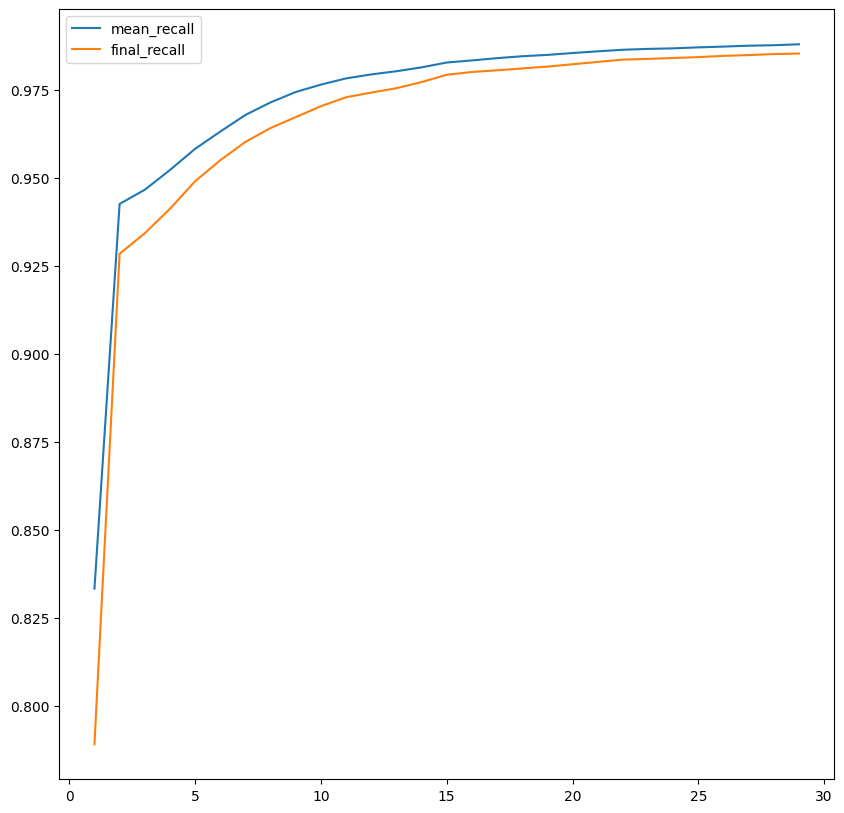

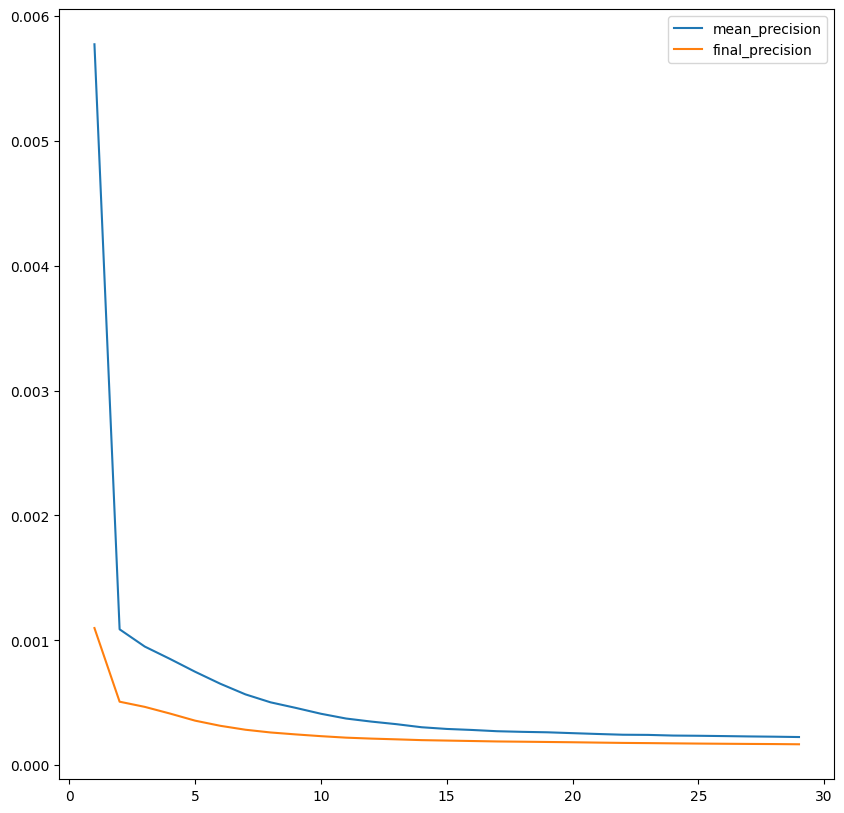

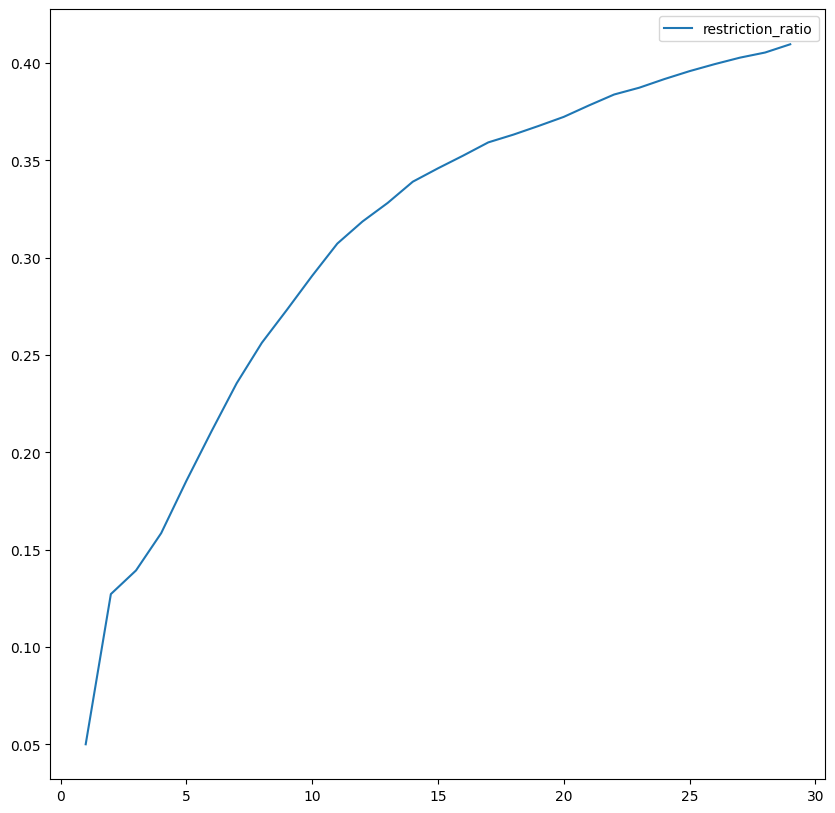

In [6]:
folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.test_topics_num_id,
                                                                   data_bert.test_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

In [ ]:
folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_test_eval_train/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.train_topics_num_id,
                                                                   data_bert.train_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

In [5]:
# seems best to pick 2 as the overshoot.
expand = 2
for node in topic_trees:
    compute_expanded_tree(node, expand)
mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
for k in range(len(data_bert.topics)):
    topic_str_id = data_bert.topics.index[k]
    node = total_nodes_by_tid[k]
    mapping[k] = node.least_subtree.topic_num_id

In [7]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train/"
test_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test/"

In [8]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [9]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_test_eval_train/"

In [10]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_test_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [11]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.test_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(test_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(test_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [12]:
def check_order(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0
        
        for topic_num_id in np.unique(topic_ids):
            left = np.searchsorted(topic_ids, topic_num_id, side="left")
            right = np.searchsorted(topic_ids, topic_num_id, side="right")
            contents_restrict_ids = content_ids[left:right]
            assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
        
        del content_ids, topic_ids
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [13]:
def check_inclusion(mfolder, train_or_test):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        
        if train_or_test == "train":
            assert (~data_bert.fast_contains_multi(data_bert.train_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.train_topics_num_id, topic_ids)).sum() == 0
        else:
            assert (~data_bert.fast_contains_multi(data_bert.test_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.test_topics_num_id, topic_ids)).sum() == 0
        
        del content_ids, topic_ids
        print(file_id)
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/", "test")
print("done")
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/", "train")

0
1
2
done
0


KeyboardInterrupt: 

In [ ]:
has_cors_content_ids = []
has_cors_topic_ids = []
def extend_correlations(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")

        contains = data_bert.has_correlations_general(data_bert.has_correlation_contents, data_bert.has_correlation_topics,
                                          content_ids, topic_ids).astype(dtype=np.int32).astype(dtype=bool)

        has_cors_content_ids.extend(list(data_bert.has_correlation_contents[contains]))
        has_cors_topic_ids.extend(list(data_bert.has_correlation_topics[contains]))
        del content_ids, topic_ids

extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [ ]:
has_cors_topic_ids = np.array(has_cors_topic_ids, dtype=np.int32)
has_cors_content_ids = np.array(has_cors_content_ids, dtype=np.int32)
sidx = np.argsort(has_cors_topic_ids)
has_cors_topic_ids = has_cors_topic_ids[sidx]
has_cors_content_ids = has_cors_content_ids[sidx]

for topic_num_id in np.unique(has_cors_topic_ids):
    left = np.searchsorted(has_cors_topic_ids, topic_num_id, side="left")
    right = np.searchsorted(has_cors_topic_ids, topic_num_id, side="right")
    assert (has_cors_topic_ids[left:right] - has_cors_topic_ids[left]).sum() == 0
    
    sub_contents = has_cors_content_ids[left:right]
    has_cors_content_ids[left:right] = np.sort(sub_contents)

In [ ]:
def check_order_generated(content_ids, topic_ids):
    assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0

    for topic_num_id in np.unique(topic_ids):
        left = np.searchsorted(topic_ids, topic_num_id, side="left")
        right = np.searchsorted(topic_ids, topic_num_id, side="right")
        contents_restrict_ids = content_ids[left:right]
        assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
check_order_generated(has_cors_content_ids, has_cors_topic_ids)

In [ ]:
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_topics.npy", has_cors_topic_ids)
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_contents.npy", has_cors_content_ids)

In [ ]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"
saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")
print(saved_files_lengths)